$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 5: Neural Networks

*Ben Newell*

## Overview

You will write and apply code that trains neural networks of various numbers of hidden layers and units in each hidden layer and returns results as specified below.  You will do this once for a regression problem and once for a classification problem. 

## Required Code

Download [nn2.tar](http://www.cs.colostate.edu/~anderson/cs440/notebooks/nn2.tar) that was used in lecture and extract its contents, which are

* `neuralnetworks.py`
* `scaledconjugategradient.py`
* `mlutils.py`

Write the following functions that train and evaluate neural network models.

* `results = trainNNs(X, T, trainFraction, hiddenLayerStructures, numberRepetitions, numberIterations, classify)`

The arguments to `trainNNs` are

* `X` is a matrix of input data of shape `nSamples x nFeatures`
* `T` is a matrix of target data of shape `nSamples x nOutputs`
* `trainFraction` is fraction of samples to use as training data. 1-`trainFraction` is number of samples for testing data
* `hiddenLayerStructures` is list of network architectures. For example, to test two networks, one with one hidden layer of 20 units, and one with 3 hidden layers with 5, 10, and 20 units in each layer, this argument would be `[[20], [5, 10, 20]]`.
* `numberRepetitions` is number of times to train a neural network.  Calculate training and testing average performance (two separate averages) of this many training runs.
* `numberIterations` is the number of iterations to run the scaled conjugate gradient algorithm when a neural network is trained.
* `classify` is set to `True` if you are doing a classification problem, in which case `T` must be a single column of target class integers.

This function returns `results` which is list with one element for each network structure tested.  Each element is a list containing 

* the hidden layer structure (as a list),
* a list of training data performance for each repetition, 
* a list of testing data performance for each repetition, and
* the number of seconds it took to run this many repetitions for this network structure.

This function should follow these steps:

  * For each network structure given in `hiddenLayerStructures`
    * For numberRepetitions
      * Use `ml.partition` to randomly partition X and T into training and testing sets.
      * Create a neural network of the given structure
      * Train it for numberIterations
      * Use the trained network to produce outputs for the training and for the testing sets
      * If classifying, calculate the fraction of samples incorrectly classified for training and testing sets.
       Otherwise, calculate the RMSE of training and testing sets.
      * Add the training and testing performance to a collection (such as a list) for this network structure
    * Add to a collection of all results the hidden layer structure, lists of training performance and testing performance, and seconds taken to do these repetitions.
  * return the collection of all results

Also write the following two functions. `summarize(results)` returns a list of lists like `results` but with the list of training performances replaced by their mean and the list of testing performances replaced by their mean.   
`bestNetwork(summary)` takes the output of `summarize(results)` and returns the best element of `results`, determined by the element that has the smallest test performance.

* `summary = summarize(results)` where `results` is returned by `trainNNs` and `summary` is like `results` with the training and testing performance lists replaced by their means
* `best = bestNetwork(summary)` where `summary` is returned by `summarize` and `best` is the best element of `summary`

Here are all of this notebooks required imports. The first three are from the supplied tar. They effectively make up the supplied neural network. Time is used for timing the individual trials. numpy is used for some of its utility functions. matplotlib.pyplot is used for plotting data about the networks. pandas is used for its ease of reading in csvs. 

In [1]:
import neuralnetworks as nn
import scaledconjugategradient as scg
import mlutils as ml
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [176]:
def trainNNs(X, Y, trainFraction, hiddenLayerStructures, numberRepetitions,
             numberIterations, classify = False, residuals = False):
    #In statistics and in the neural net code, the "target" matrix is Y
    #I'm more used to this.
    results = []
    start = time.time()
    for structure in hiddenLayerStructures:
        trainedList = []
        testedList = []
        for _ in range(numberRepetitions):
            #Unsure about what the validation return does.
            Xtrain,Ytrain,Xtest,Ytest = ml.partition(X, Y, 
                                        (trainFraction, 1 - trainFraction), False)
            #create nn with the right structure.
            #initiallizes ni->columns of X
            #             no->columns of Y
            #             nhs->our given structure in hidden layers
            if not classify:
                nnet = nn.NeuralNetwork(X.shape[1], structure, Y.shape[1])
            else:
                nnet = nn.NeuralNetworkClassifier(X.shape[1],structure, len(np.unique(Y)))
            #Train for number of iterations.
            nnet.train(Xtrain, Ytrain, numberIterations)
            #collect the trained outputs with training data and test data
            predictedYTrained = nnet.use(Xtrain)
            predictedYTested = nnet.use(Xtest)
            #calculate the mean standard error for these dudes.
            # VVVVVVVV THE BELOW IS FOR SIGMA SQUARED, DATA ITSELF
            # not the statistically correct way of doing it, need n - estimated paramaters df.
            # so for simple regression n -2 df, = number of columns in X with column of ones.
            #Difference between measuring the amount of error and trying to estimate
            #Epsilons in the model.
            if not classify:
                rmseTrained = np.sqrt(np.mean((Ytrain - predictedYTrained) ** 2))
                rmseTested = np.sqrt(np.mean((Ytest - predictedYTested) ** 2))
            else:
                rmseTrained =(1 - sum(Ytrain.ravel()==predictedYTrained.ravel())/ float(len(Ytrain))) * 100
                rmseTested =(1 - sum(Ytest.ravel()==predictedYTested.ravel())/ float(len(Ytest))) * 100
            #could also save the residuals here and talk about trends...
            trainedList.append(rmseTrained)
            testedList.append(rmseTested)
        end = time.time()
        results.append([structure, trainedList, testedList, end - start])
        if residuals:
            results.append([Ytrain - predictedYTrained, Ytest - predictedYTested])            
    return results

Although not required, I've implemented a regular linear regression method here. It finds the Ordinary Least Squares estimator of the linear model. I return the rmse to compare it to the neural networks created throughout the project, and the matrix of betas that can be used to use the model. 

In [3]:
def linearRegression(X,Y):
    newX = np.c_[np.ones(len(X)), X] #Adds a column of ones to the beginning for intercept.
    #This finds the OLS estimator for the model
    #beta = (XtX)-1XtY. Thanks cooley!
    betas = np.linalg.inv((np.transpose(newX) @ newX)) @ np.transpose(newX) @ Y
    # our prediction will the be Xo @ beta.
    predictedYs = newX @ betas
    rmse = np.sqrt(np.mean((predictedYs - Y) ** 2))
    #not sdhat     |msres~~~~~~~~~~~~~~~~~~~~~~~~~| <- actually not, should be adjusted for df.
    return rmse, betas

In [4]:
def summarize(results):
    summarized = list(range(len(results)))
    for t in range(len(results)):
        summarized[t] = [results[t][0], np.mean(results[t][1]), np.mean(results[t][2]), results[t][3]]
    return summarized

In [165]:
def bestNetwork(summary):
    lowestError = float('inf')
    lowestNetwork = summary[0]
    for s in summary:
        if s[2] < lowestError:
            lowestError = s[2]
            lowestNetwork = s
        
    return lowestNetwork
#NOT NEEDED
#the definition of best for these is opposite
def bestNetworkClassification(summary):
    highestPercent = 0;
    highestNetwork = summary[0]
    for s in summary:
        if s[2] > highestPercent:
            highestPercent = s[2]
            highestNetwork = s
    return highestNetwork

## Examples


In [6]:
%matplotlib inline

In [7]:
X = np.arange(10).reshape((-1,1))
T = X + 1 + np.random.uniform(-1, 1, ((10,1)))

In [8]:
Xtrain,Train, Xtest,Ttest =ml.partition(X, T, (0.7, 0.3), False)

In [9]:
X

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [10]:
print(Xtrain)
print(Train)
print(Xtest)
print(Ttest)
print(X)
print(T)

[[9]
 [3]
 [0]
 [4]
 [6]
 [7]
 [8]]
[[10.89424218]
 [ 3.99255954]
 [ 0.78539209]
 [ 5.32849101]
 [ 7.82124644]
 [ 7.06575746]
 [ 9.67918442]]
[[2]
 [5]
 [1]]
[[2.3881754 ]
 [5.92449829]
 [1.6661739 ]]
[[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]
[[ 0.78539209]
 [ 1.6661739 ]
 [ 2.3881754 ]
 [ 3.99255954]
 [ 5.32849101]
 [ 5.92449829]
 [ 7.82124644]
 [ 7.06575746]
 [ 9.67918442]
 [10.89424218]]


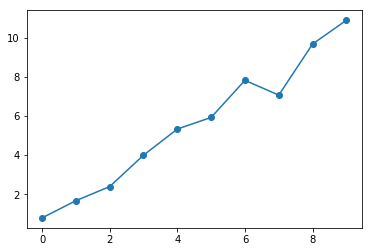

In [11]:
plt.plot(X, T, 'o-');

In [12]:
nnet = nn.NeuralNetwork(X.shape[1], 2, T.shape[1])
nnet.train(X, T, 100)
nnet.getErrorTrace()

array([0.70710678, 0.12918593, 0.11512843, 0.11498691, 0.11497268,
       0.11472728, 0.11392082, 0.11353898, 0.11349255, 0.11299397,
       0.11294893, 0.11293888, 0.11280089, 0.11279172, 0.11279172,
       0.11279172, 0.11279172, 0.11279172, 0.11279172, 0.11279172,
       0.11279172, 0.11279172, 0.11279172, 0.11279172, 0.11279172,
       0.11260567, 0.1116486 , 0.11161301, 0.11137455, 0.11134479,
       0.11134339, 0.11133243, 0.1112952 , 0.11128079, 0.11127531,
       0.1112152 , 0.11121226, 0.11113611, 0.11113051, 0.11108149,
       0.11104527, 0.1110406 , 0.1109984 , 0.11099364, 0.1109321 ,
       0.11090112, 0.11090112, 0.11090112, 0.11090112, 0.11090112,
       0.11090112, 0.11090112, 0.11090112, 0.11090112, 0.11090112,
       0.11090112, 0.11063922, 0.11052738, 0.11051619, 0.11042732,
       0.11037691, 0.11037691, 0.11037691, 0.11003676, 0.1100367 ,
       0.10961299, 0.10951558, 0.1093555 , 0.1093453 , 0.10931673,
       0.10930435, 0.10930435, 0.10930435, 0.10930435, 0.10908

In [13]:
nnet = nn.NeuralNetwork(X.shape[1], [5, 5, 5], T.shape[1])
nnet.train(X, T, 100)
nnet.getErrorTrace()

array([0.70710678, 0.3791626 , 0.3791626 , 0.3791626 , 0.3791626 ,
       0.3791626 , 0.3791626 , 0.3791626 , 0.3791626 , 0.3791626 ,
       0.3791626 , 0.31081566, 0.20745166, 0.17439222, 0.12766226,
       0.1270329 , 0.12643874, 0.12172076, 0.11982146, 0.1141798 ,
       0.11304266, 0.11231167, 0.11076172, 0.110538  , 0.11030181,
       0.10906318, 0.10823969, 0.10603134, 0.10396355, 0.10367794,
       0.10360662, 0.10351284, 0.10338982, 0.10324631, 0.10322722,
       0.10309378, 0.10185245, 0.10085803, 0.09941816, 0.09898609,
       0.09869123, 0.09848059, 0.09823173, 0.09741213, 0.09654086,
       0.09644271, 0.09641263, 0.09617706, 0.0953908 , 0.09518229,
       0.0948084 , 0.09476756, 0.09446319, 0.09439982, 0.09435909,
       0.09376985, 0.0934011 , 0.0931468 , 0.09309116, 0.09301244,
       0.09297248, 0.09287536, 0.09270018, 0.09268487, 0.092679  ,
       0.09240927, 0.09227761, 0.09205422, 0.09160296, 0.09154976,
       0.09153083, 0.09147347, 0.09147277, 0.09146993, 0.09141

In [14]:
results = trainNNs(X, T, 0.8, [2, 10, [10, 10]], 5, 100, classify=False)
results

[[2,
  [0.518999818995279,
   0.45825958413146906,
   0.5106672653488212,
   0.19968148415578177,
   0.45940410389069464],
  [0.10841065403357449,
   0.8464863363533626,
   0.4115053255735229,
   1.1954710523896446,
   0.24928396299285918],
  0.08630228042602539],
 [10,
  [0.20013044393037102,
   0.40944324487518885,
   0.03952206515484427,
   0.44903581246197594,
   0.45544792779957666],
  [1.2316484586411123,
   0.6690955466687777,
   1.3940637305952837,
   0.7185245258206282,
   0.3879650200264065],
  0.17310309410095215],
 [[10, 10],
  [0.43059814438352445,
   0.4161910136764814,
   0.07731576442997419,
   0.3449855114475281,
   0.09983044184011473],
  [0.41854978576937824,
   0.8608342602074378,
   1.3072210322388411,
   1.1380464722650079,
   1.8862531557330453],
  0.30185699462890625]]

In [15]:
results = trainNNs(X, T, 0.8, [0, 1, 2, 10, [10, 10], [5, 5, 5, 5], [2]*5], 50, 100, classify=False)

In [16]:
summarize(results)

[[0, 0.4733824165948905, 0.5135222800957089, 0.01844644546508789],
 [1, 0.4495931894183331, 0.6298370499873888, 0.7831287384033203],
 [2, 0.39254208415437375, 0.7247673187140786, 1.5807857513427734],
 [10, 0.3191142300696245, 0.8493281085445201, 2.459808111190796],
 [[10, 10], 0.25995748000276314, 1.116679656529771, 3.6735589504241943],
 [[5, 5, 5, 5], 0.3644858990851654, 0.86017119762591, 5.441510915756226],
 [[2, 2, 2, 2, 2], 0.44471176537241325, 0.7048981651821914, 7.232424736022949]]

In [17]:
model = linearRegression(X, T)

Here we print out the model, which takes the form of RMSE, array of betas (Weights)

In [18]:
model

(0.4991562861148287, array([[0.57618927],
        [1.10630729]]))

Linear regression plot of model versus line

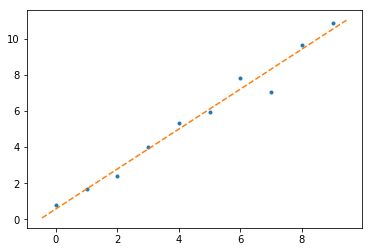

In [19]:
def abline(slope, intercept):
    #borrowed from: 
    #https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

plt.plot(X, T, ".")
abline(model[1][1], model[1][0])

In [20]:
best = bestNetwork(summarize(results))
print(best)
print('Hidden Layers {} Average RMSE Training {:.2f} Testing {:.2f} Took {:.2f} seconds'.format(*best))

[0, 0.4733824165948905, 0.5135222800957089, 0.01844644546508789]
Hidden Layers 0 Average RMSE Training 0.47 Testing 0.51 Took 0.02 seconds


Hummm...neural nets with no hidden layers did best on this simple data set.  Why?  Remember what "best" means.

Because its a linear trend!

## Data for Regression Experiment

From the UCI Machine Learning Repository, download the [Appliances energy prediction](http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction) data.  You can do this by visiting the Data Folder for this data set, or just do this:

     !wget http://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv



Read this data into python.  One suggestion is to use the `loadtxt` function in the `numpy` package.  You may ignore the first column of each row which contains a data and time.  Also ignore the last two columns of random variables.  We will not use that in our modeling of this data.  You will also have to deal with the double quotes that surround every value in every field.  Read the first line of this file to get the names of the features.

Once you have read this in correctly, you should see values like this:

Here is where the data from `energydata_complete.csv` is read in. This uses pandas, which has a function to read a csv into a pandas dataframe really easily! It handles the double quotes just fine as well, correctly reading the values as floats. In order to drop columns from a pandas dataframe, the drop function with a list of names to remove is used. This removes the date, rv1 and rv2 columns from the dataframe.

In [21]:
csv = pd.read_csv("energydata_complete.csv")
#drop unneeded columns
csv = csv.drop(['date', 'rv1', 'rv2'], axis = 1)

Here are the columns loaded in from the csv. I do not read this into its own variable names. 

In [22]:
#names
csv.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint'],
      dtype='object')

The dataframe still needs to be converted to a numpy array however. Luckily, this is easy to do. 

In [23]:
data = csv.values #.values is a numpy array! 
data.shape

(19735, 26)

Here are a few sample rows. The first two, appliances and lights, are the targets of the model. 

In [25]:
data[:2,:]

array([[ 60.        ,  30.        ,  19.89      ,  47.59666667,
         19.2       ,  44.79      ,  19.79      ,  44.73      ,
         19.        ,  45.56666667,  17.16666667,  55.2       ,
          7.02666667,  84.25666667,  17.2       ,  41.62666667,
         18.2       ,  48.9       ,  17.03333333,  45.53      ,
          6.6       , 733.5       ,  92.        ,   7.        ,
         63.        ,   5.3       ],
       [ 60.        ,  30.        ,  19.89      ,  46.69333333,
         19.2       ,  44.7225    ,  19.79      ,  44.79      ,
         19.        ,  45.9925    ,  17.16666667,  55.2       ,
          6.83333333,  84.06333333,  17.2       ,  41.56      ,
         18.2       ,  48.86333333,  17.06666667,  45.56      ,
          6.48333333, 733.6       ,  92.        ,   6.66666667,
         59.16666667,   5.2       ]])

Use the first two columns, labelled `Appliances` and `lights` as the target variables, and the remaining 24 columns as the input features.  So we split off the first two columns into the target matrix, and the remaining into the X matrix. 

In [ ]:
Tenergy = data[:, :2]
Xenergy = data[:, 2:]

In [ ]:
Xenergy.shape, Tenergy.shape

Train several neural networks on all of this data for 100 iterations.  Plot the error trace (nnet.getErrorTrace()) to help you decide now many iterations might be needed.  100 may not be enough.  If for your larger networks the error is still decreasing after 100 iterations you should train all nets for more than 100 iterations.

Now use your `trainNNs`, `summarize`, and `bestNetwork` functions on this data to investigate various network sizes.

In [177]:
results = trainNNs(Xenergy, Tenergy, 0.8, [0, 5, [5, 5], [10, 10]], 10, 100)

In [32]:
summarize(results)

[[0, 67.0119220291367, 67.7873824983066, 0.7857398986816406],
 [5, 65.28282314337837, 65.54429699191795, 7.517106771469116],
 [[5, 5], 65.03531799352909, 65.30075957627932, 16.302370309829712],
 [[10, 10], 62.77482764041488, 64.2704059870164, 28.526667594909668]]

In [33]:
bestNetwork(summarize(results))

[[10, 10], 62.77482764041488, 64.2704059870164, 28.526667594909668]

Test at least 10 different hidden layer structures.  Larger numbers of layers and units may do the best on training data, but not on testing data. Why?

Now train another network with your best hidden layer structure on 0.8 of the data and use the trained network on the testing data (the remaining 0.2 of the date).  As before use `ml.partition` to produce the training and testing sets.

For the testing data, plot the predicted and actual `Appliances` energy use, and the predicted and actual `lights` energy use, in two separate plots.  Discuss what you see.

### Finding  a (reasonable) Number of Iterations.
Finding the proper number of iterations. It continues to reduce over time, but around 400 seems to be a good sweet spot in terms of runtime. 

In [79]:
#Create and train the nn.
#Do this with 1000, but maybe on your desktop.
testNN = nn.NeuralNetwork(Xenergy.shape[1], [10,10], Tenergy.shape[1])
Xtrain,Ytrain,Xtest,Ytest=ml.partition(Xenergy, Tenergy, (.8, .2), False)
testNN.train(Xtrain, Ytrain, 1000) #300 should be fine
#Final error is not the same as RMSE


NeuralNetwork(24, [10, 10], 2)
   Network was trained for 1001 iterations. Final error is 0.5394427796165684.

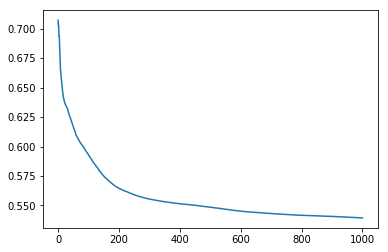

In [80]:
plt.plot(bestNN.getErrorTrace())

### Testing structures
Here we try some interesting and large neural net structures. I broke it into two stages because of how long they take. I tried to get a wide variety of structures too. The first run found just 100 to be the best, implying that the sheer number of hidden units is favored. [20,20] also did quite well. 

In [82]:
results = trainNNs(Xenergy, Tenergy, 0.8, [0, [1,1,1,1,1,1], [5, 5, 5], [20, 20], [10, 10, 10, 10],[100]], 10, 400)

In [85]:
summarize(results)

[[0, 67.33032919191253, 66.49118453892186, 0.8347780704498291],
 [[1, 1, 1, 1, 1, 1], 69.97741144764575, 70.25745458631054, 20.21030282974243],
 [[5, 5, 5], 63.09756731614442, 64.92000926454517, 60.75912380218506],
 [[20, 20], 52.8496572295128, 59.78772428389192, 138.05959963798523],
 [[10, 10, 10, 10], 56.969469270275496, 63.39168433771374, 210.96005415916443],
 [[100], 52.92414386395851, 58.228311834909505, 418.4718759059906]]

I followed up on the previous structures to see whether more hidden layers  or hidden units is effective. The first two structures have the same number of units but with different layering. The difference between these can show whether breaking into layers is helpful for the neural network to pick up trends. Then I double the amount of units for the last structure, to see how much performance comes from brute force. 400 seems to be taking an absurd amount of time. I probably will not use that again if I can avoid it. 

In [100]:
resultsPlus = trainNNs(Xenergy, Tenergy, 0.8, [0, [20, 20, 20, 20], 
                                                [50,50,50,50], [200]], 10, 400)

In [102]:
summarize(resultsPlus)

[[0, 67.17327210457066, 67.14093638835263, 0.7700586318969727],
 [[20, 20, 20, 20], 47.20646818406259, 60.51538959553417, 137.62338042259216],
 [[50, 50, 50, 50], 43.245099013072625, 55.01606475671939, 664.0171720981598],
 [[200], 51.46236082423652, 57.58437924277861, 1223.3430888652802]]

Training the best neural network and analyzing the results.

In [106]:
resultsPlus = restultsPlus
print(bestNetwork(summarize(results)))
print(bestNetwork(summarize(resultsPlus)))

[[100], 52.92414386395851, 58.228311834909505, 418.4718759059906]
[[50, 50, 50, 50], 43.245099013072625, 55.01606475671939, 664.0171720981598]


In [108]:
bestNN = nn.NeuralNetwork(Xenergy.shape[1], [50,50,50,50], Tenergy.shape[1])
Xtrain,Ytrain,Xtest,Ytest=ml.partition(Xenergy, Tenergy, (.8, .2), False)
bestNN.train(Xtrain, Ytrain, 400) #300 should be fine

NeuralNetwork(24, [50, 50, 50, 50], 2)
   Network was trained for 401 iterations. Final error is 0.41391912948847.

Here we will test the neural network by comparing its predicted results to the actual results. 

In [109]:
Ypredicted = bestNN.use(Xenergy)

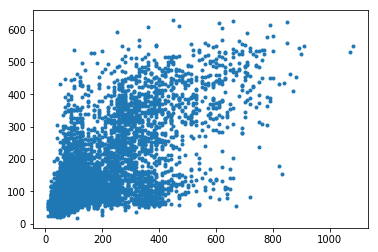

In [210]:
plt.plot(Tenergy[:,0], Ypredicted[:,0], ".")

This graph shows the actual vs predicted value of appliance using the "best" neural network. There at least appears to be a postive trend, but it is not a clean predictive graph. One of the biggest trends is that the network does not ever predict high values. The actual data has outputs all the way up to 1000, but because so many of the outputs are much lower, the neural network has not learned to output values that high frequently. 

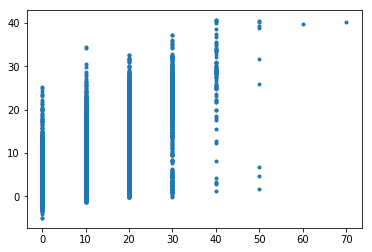

In [112]:
plt.plot(Tenergy[:,1], Ypredicted[:,1], ".")

Here we will take a close look at the graph above by expanding one of the vertical stripes.

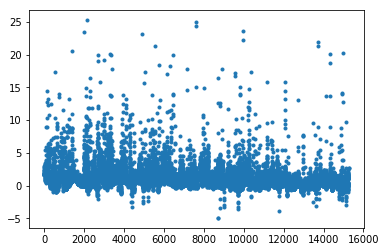

In [138]:
zeroIndices = np.where(Tenergy[:,1] == 0)
zeroIndices
vals = Ypredicted[zeroIndices,1]
plt.plot(vals.transpose(), ".")

Here is a plot of the actual vs predicted at only the actual values of zero. This gives a better visual than the graph above by not collapsing all of the observations onto one axis. According to this graph, the neural network seems to actually be doing a good jop of predicting near zero when the input results in zero. 

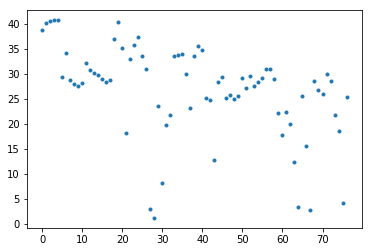

In [137]:
fortyIndices = np.where(Tenergy[:,1] == 40)
fortyIndices
vals = Ypredicted[fortyIndices,1]
plt.plot(vals.transpose(), ".")

When we pick a higher traget though, the picture is not nearly as good. The neural network does not seem to have any pattern to its predictions when the result should be forty. Although much of this is because there are simply not many samples that have this target value.

This compares the lights data with the same predicted vs actual structure. This shows an interesting trend about the lights data. Only the values [0,20,30,40,50,60,70] appear in the dataset, but the neural network outputs data all over the place, and never abouve 30. Because of this binning of lights, its possible a classification could work better. 

Here are some plots of residuals! I encluded these just to see if any clear trends could be found even though they are not required. 

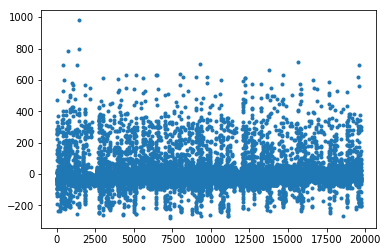

In [50]:
plt.plot(Tenergy[:,0] - Ypredicted[:,0], ".")

This does not look so bad, especially compared to the plot of predicted vs actual. There is a definite positive bias in the residuals that could indicate some consistent errors in the model. There is also some stripping issues. This could be something in the data that throws off the model, like a certain variable that tends to make it predict wrongly. 

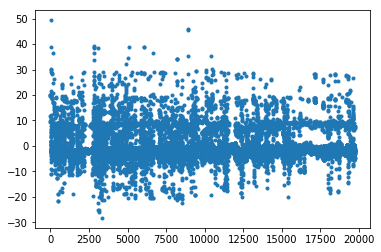

In [51]:
plt.plot(Tenergy[:,1] - Ypredicted[:,1], ".")

This residual plot for lights is really interesting. You can see the horizontal stripes of consitent erro. These move in ten step increments, showing that the model is sort of misclassifying the data. 

If you were stuck on a desert island with a raspberry pi, this might be the fastest way to go. 

Here, plot the residuals of the best versus the residuals of the linear regression to see what sort of trend neural net might have picked up. 

In [86]:
mod = linearRegression(Xenergy, Tenergy)

In [89]:
mod
#adds a column of ones for intercept.
XenergyPrime = np.c_[np.ones(len(Xenergy)), Xenergy] 
linearPrediction = XenergyPrime @ mod[1]

In [ ]:
plt.plot(plt.plot(Tenergy[:,0], linearPrediction[:,0], "."))

In [ ]:
plt.plot(plt.plot(Tenergy[:,1], linearPrediction[:,1], "."))

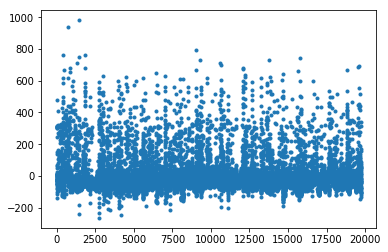

In [97]:
plt.plot(Tenergy[:,0] - linearPrediction[:,0], ".")

The residual plot of the linear regression for appliances looks similar to the one produced by the neural network. It helps to show that the positive bias of the residuals was not due to something wrong with the network, but rather a bias and non-normality in the data. 

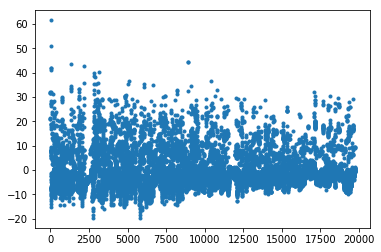

In [139]:
plt.plot(Tenergy[:,1] - linearPrediction[:,1], ".")

Here we see a different picture than the residuals created by the neural network when predicting for lights. The striping does not really appear here, probably because the simple linear regression can not pick up on the binned nature of the data while the neural network does. 

## Data for Classification Experiment

From the UCI Machine Learning Repository, download the [Anuran Calls (MFCCs)](http://archive.ics.uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29) data.  You can do this by visiting the Data Folder for this data set, or just do this:

     !wget 'http://archive.ics.uci.edu/ml/machine-learning-databases/00406/Anuran Calls (MFCCs).zip'
     !unzip Anuran*zip
     
Read the data in the file `Frogs_MFCCs.csv` into python.  This will be a little tricky. Each line of the file is a sample of audio features plus three columns that label the sample by family, genus, and species. We will try to predict the species.  The tricky part is that the species is given as text.  We need to convert this to a target class, as an integer. The `numpy` function `unique` will come in handy here.

In [52]:
csv = pd.read_csv("Frogs_MFCCs.csv")
csv = csv.drop(['RecordID', 'Family', 'Genus', 'MFCCs_ 1'], axis = 1) #also drops MFCCs_1, 
                                                                    #which only has the value 1, no in his.

In [53]:
csv.shape

(7195, 22)

Here we convert the pandas data frame into a numpy matrix. It is mostly striaghtforward like the regression data, except for the typing. For some reason pandas read the call data as python floats, which cannot be used like numpy floats. This caused me a giant headache and threw all sorts of weird errors later on. Eventually I worked my way back here and realized I needed to change the matrix to use numpy.float64 instead of python float.

In [54]:
data = csv.values
Tanuran = data[:, 21:]
Xanuran = data[:, :21]
Xanuran = Xanuran.astype(np.float64)
#print(type(Xanuran[1,1]))
#print(Xanuran.astype(np.float64))
#print(type(Xenergy[1,1]))

In [83]:
Xanuran.shape, Tanuran.shape

((7195, 21), (7195, 1))

In [84]:
Xanuran[:2,:]

array([[ 0.15, -0.11,  0.2 ,  0.32,  0.26,  0.1 , -0.15, -0.17,  0.12,
         0.19, -0.08, -0.16,  0.08,  0.14, -0.02, -0.11, -0.08, -0.01,
         0.06,  0.12,  0.01],
       [ 0.17, -0.1 ,  0.27,  0.34,  0.27,  0.06, -0.22, -0.21,  0.17,
         0.27, -0.1 , -0.25,  0.02,  0.16,  0.01, -0.09, -0.06, -0.04,
         0.02,  0.08,  0.03]])

In [57]:
names = np.unique(Tanuran)
names = list(names)
for i in range(len(Tanuran)):
    Tanuran[i] = names.index(Tanuran[i])
#Tanuran = [names.index(n) for n in Tanuran]
#Tanuran = [[x] for x in Tanuran]
#Tanuran = np.array(Tanuran)

In [65]:
Xanuran.shape[1]

21

In [62]:
Tanuran = Tanuran.astype(np.int)
Tanuran[:2]

array([[0],
       [0]])

In [63]:
for i in range(10):
    print('{} samples in class {}'.format(np.sum(Tanuran==i), i))

672 samples in class 0
3478 samples in class 1
542 samples in class 2
310 samples in class 3
472 samples in class 4
1121 samples in class 5
270 samples in class 6
114 samples in class 7
68 samples in class 8
148 samples in class 9


In [178]:
results = trainNNs(Xanuran, Tanuran, 0.8, [0, 5, [5, 5]], 10, 100, classify=True)

In [179]:
summarize(results)

[[0, 2.738012508686589, 3.7665045170257114, 2.0394036769866943],
 [5, 3.571924947880474, 4.808895066018069, 6.026899576187134],
 [[5, 5], 6.064975677553856, 6.858929812369702, 10.823338508605957]]

In [181]:
bestNetwork(summarize(results))

[0, 2.738012508686589, 3.7665045170257114, 2.0394036769866943]

### Finding a  reasonable number of iterations
Follow the same logic as last time. We run on the most complex of the preliminary structures above to see if it is getting enough time to learn. 

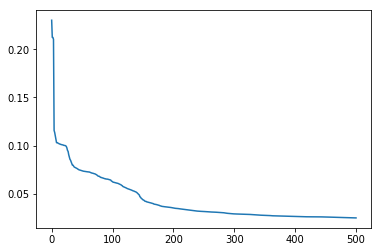

In [161]:
#Create and train the nn.
#Do this with 1000, but maybe on your desktop.
testNN = nn.NeuralNetworkClassifier(Xanuran.shape[1], [5,5], len(np.unique(Tanuran)))
Xtrain,Ytrain,Xtest,Ytest=ml.partition(Xanuran, Tanuran, (.8, .2), False)
testNN.train(Xtrain, Ytrain, 500) #300 should be fine
#Final error is not the same as RMSE
plt.plot(testNN.getErrorTrace())

Following this trial, 250 should give enough iterations. More complex models may need more time to learn the model, but without GPU acceleration I will not have the time!

## Testing Structures
Like last time, testing will be broken up. This makes it more reasonable to rerun some of the tests from a time standpoint.

Now do an investigation like you did for the regression data. 

Test at least 10 different hidden layer structures. Then train another network with your best hidden layer structure on 0.8 of the data and use the trained network on the testing data (the remaining 0.2 of the date). 

Plot the predicted and actual `Species` for the testing data as an integer.  Discuss what you see.

In [187]:
results = trainNNs(Xanuran, Tanuran, 0.8, [0, [1,1,2,3,5,8,13,21], [20,10,5, 5,10, 20], [100]], 5, 250, classify=True)

In [196]:
summarize(results),bestNetwork(summarize(results))

([[0, 2.755385684503126, 3.794301598332175, 2.624049425125122],
  [[1, 1, 2, 3, 5, 8, 13, 21],
   32.26198749131341,
   31.466296038915914,
   17.614604473114014],
  [[20, 10, 5, 5, 10, 20],
   1.431549687282836,
   3.7248088950660163,
   35.25487017631531],
  [[100], 0.0, 1.0701876302988178, 57.074690103530884]],
 [[100], 0.0, 1.0701876302988178, 57.074690103530884])

Looks like the fibbonacci network is not very effective. The second structure is not too bad, works better than a regression. The big network worked very well on the training data, but also worked well on the test data. With that many hidden units, it could be that the neural network is learning every training input.

In [184]:
resultsTwo = trainNNs(Xanuran, Tanuran, 0.8, [200, [50, 2, 50], [2]*20], 5, 250, classify=True)

In [195]:
summarize(resultsTwo),bestNetwork(summarize(resultsTwo))

([[200, 0.0, 0.9173036831132751, 39.51124119758606],
  [[50, 2, 50], 5.319666435024324, 8.408617095205004, 59.8610405921936],
  [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
   51.4593467685893,
   52.46699096594857,
   62.307069063186646]],
 [200, 0.0, 0.9173036831132751, 39.51124119758606])

Here I tried another odd structure to see how it would behave. Looks like a whole bunch of layers with few units does not do a good job of classifying. The 200 hidden unit structure continued to improve upon the last large structure, although continuing to add units may not work well. Also interesting to see was the [50,2,50] structure, which still classified well even with the chokepoint. 

In [188]:
resultsThree = trainNNs(Xanuran, Tanuran, 0.8, [[10,10], [5, 5, 5]], 5, 250, classify=True)

In [192]:
summarize(resultsThree),bestNetwork(summarize(resultsThree))

[[[10, 10], 0.13551077136900513, 2.8630993745656697, 7.665461540222168], [[5, 5, 5], 2.8978457261987485, 4.072272411396802, 14.866990804672241]]


[[10, 10], 0.13551077136900513, 2.8630993745656697, 7.665461540222168]

Of all of the network structures tested, the 200 hidden unit performed the best. This has a high change of over fitting the model however, and it may be better to use a simpler model to be able to more easily interpret the data. A simple network without any hidden units classifies correctly 3.79% of the time on test data, so it may be worth choosing for its simplicity over difficult to interpret hidden units. For analyses, I will look at the [10,10] network. Even though it did not perform the best, it does not have as much of a chance of over fitting ast the other models. 

In [199]:
bestNN = nn.NeuralNetworkClassifier(Xanuran.shape[1], [10,10], len(np.unique(Tanuran)))
Xtrain,Ytrain,Xtest,Ytest=ml.partition(Xanuran, Tanuran, (.8, .2), False)
bestNN.train(Xtrain, Ytrain, 250) #300 should be fine

NeuralNetwork(21, [10, 10], 10)
   Network was trained for 250 iterations. Final error is 0.00047599250155310824.

We see that the error is low, so the network is well trained. We will continue by looking at the amount of correctly classified frogs.

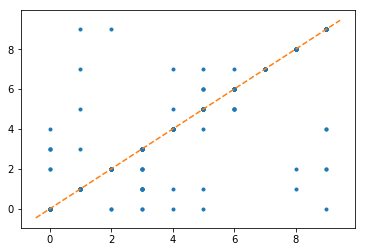

In [206]:
predictedClass = bestNN.use(Xanuran)
plt.plot(predictedClass, Tanuran, ".")
abline(1,0)

Looks like a good looking line! Its hard to tell the proportion of mis classifications though. So lets try some other graphs?

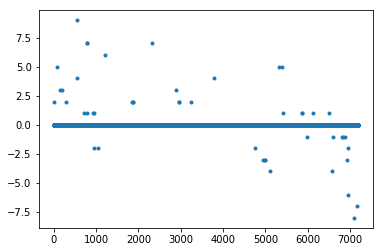

In [207]:
plt.plot(predictedClass - Tanuran, ".")

(array([2.00e+00, 1.00e+00, 2.00e+00, 4.00e+00, 9.00e+00, 7.15e+03,
        9.00e+00, 1.10e+01, 2.00e+00, 4.00e+00, 3.00e+00, 1.00e+00]),
 array([-8.  , -6.58, -5.17, -3.75, -2.33, -0.92,  0.5 ,  1.92,  3.33,
         4.75,  6.17,  7.58,  9.  ]),
 <a list of 12 Patch objects>)

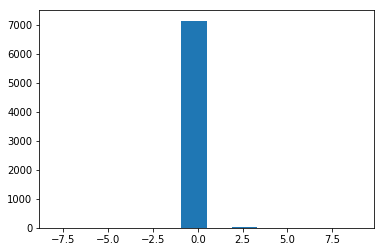

In [233]:
plt.hist(predictedClass - Tanuran, bins = 12)

This extremely meaningful histogram is terrible and should be deleted. 

Residuals are not as meaningful when using classification either. If this was a normal linear regression, we would worry about normality. However, a correct classification of 9 can only really have negative error. So this graph does not really say much else either. 

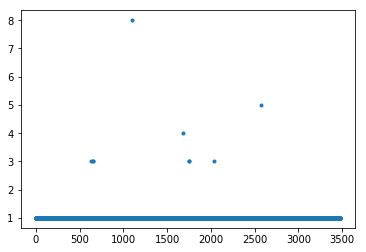

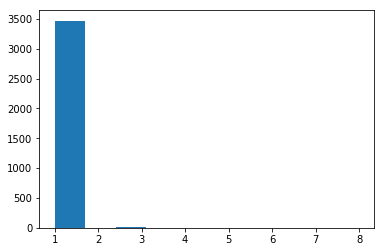

In [236]:
#plt.hist([0,1,2,4,5,5,5,5,5,6,7,8,9], bins=9)
indices = np.where(Tanuran[:,0] == 1)
indices
vals = predictedClass[indices,0]
plt.plot(vals.transpose(), ".")
plt.show()
plt.hist(vals.transpose())
plt.show()

These plots might do the best job at getting across how well this classification works. Out of the few thousand inputs, only a handful are mis-classified. 

## Grading

Download [A5grader.tar](http://www.cs.colostate.edu/~anderson/cs440/notebooks/A5grader.tar) and extract `A5grader.py` from it.

In [78]:
%run -i "A5grader.py"


======================= Code Execution =======================

Extracting python code from notebook named 'Newell-A5.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing summarize([[[1,1], [1.2, 1.3, 1.4], [2.2, 2.3, 2.4], 0.5], [[2,2,2], [4.4, 4.3, 4.2], [6.5, 6.4, 6.3], 0.6]])

--- 10/10 points. Correctly returned [[[1, 1], 1.3, 2.3000000000000003, 0.5], [[2, 2, 2], 4.3, 6.3999999999999995, 0.6]]

Testing bestNetwork([[[1, 1], 1.3, 2.3, 0.5], [[2, 2, 2], 4.3, 1.3, 0.6]])

--- 10/10 points. Correctly returned [[2, 2, 2], 4.3, 1.3, 0.6]

X = np.random.uniform(-1, 1, (100, 3))
T = np.hstack(((X**2 - 0.2*X**3).sum(axis=1,keepdims=True),
               (np.sin(X)).sum(axis=1,keepdims=True)))
result = trainNNs(X, T, 0.7, [0, 5, 10, [20, 20]], 10, 100, False)

--- 20/20 points. Correct.

Testing bestNetwork(summarize(result))

--- 20/20 points. You correctly found that network [20, 20] is best.

cs440 Execution Gr

<Figure size 432x288 with 0 Axes>

## Check-in

Do not include this section in your notebook.

Name your notebook ```Lastname-A5.ipynb```.  So, for me it would be ```Anderson-A5.ipynb```.  Submit the file using the ```Assignment 5``` link on [Canvas](https://colostate.instructure.com/courses/68135).

## Extra Credit

  2. Repeat the above regression and classification experiments with a second regression data set and a second classification data set.
  
  2. Since you are collecting the performance of all repetitions for each network structure, you can calculate a confidence interval about the mean, to help judge significant differences. Do this for either the regression or the classification data and plot the mean test performance with confidence intervals for each network structure tested.  Discuss the statistical significance of the differences among the means.  One website I found to help with this is the site [Correct way to obtain confidence interval with scipy](https://stackoverflow.com/questions/28242593/correct-way-to-obtain-confidence-interval-with-scipy).
  
